In this project you will experiment with a padding oracle attack against a toy web site hosted at  crypto-class.appspot.com .  Padding oracle vulnerabilities affect a wide variety of products, including secure tokens .

This project will show how they can be exploited.   We discussed CBC padding oracle attacks in week 4 (segment number 6), but if you want to read more about them, see a short description here or Vaudenay's paper on this topic.

Now to business.    Suppose an attacker wishes to steal secret information from our target web site  crypto-class.appspot.com . The attacker suspects that the web site embeds encrypted customer data in URL parameters such as this:

http://crypto-class.appspot.com/po?er=f20bdba6ff29eed7b046d1df9fb7000058b1ffb4210a580f748b4ac714c001bd4a61044426fb515dad3f21f18aa577c0bdf302936266926ff37dbf7035d5eeb4

That is, when customer Alice interacts with the site, the site embeds a URL like this in web pages it sends to Alice.  The attacker intercepts the URL listed above and guesses that the ciphertext following the "po?er=" is a hex encoded AES CBC encryption with a random IV of some secret data about Alice's session.

After some experimentation the attacker discovers that the web site is vulnerable to a CBC padding oracle attack. In particular, when a decrypted CBC ciphertext ends in an invalid pad the web server returns a 403 error code (forbidden request). When the CBC padding is valid, but the message is malformed, the web server returns a 404 error code (URL not found).

Armed with this information your goal is to decrypt the ciphertext listed above.  To do so you can send arbitrary HTTP requests to the web site of the form

http://crypto-class.appspot.com/po?er= "your ciphertext here"

and observe the resulting error code.  The padding oracle will let you decrypt the given ciphertext one byte at a time.   To decrypt a single byte you will need to send up to 256 HTTP requests to the site.  Keep in mind that the first ciphertext block is the random IV. The decrypted message is ASCII encoded.

To get you started here is a  short Python script  that sends a ciphertext supplied on the command line to the site and prints the resulting error code.  You can extend this script (or write one from scratch) to implement the padding oracle attack.  Once you decrypt the given ciphertext, please enter the decrypted message in the box below.   

This project shows that when using encryption you must prevent padding oracle attacks by either using encrypt-then-MAC as in EAX or GCM, or if you must use MAC-then-encrypt then ensure that the site treats padding errors the same way it treats MAC errors.

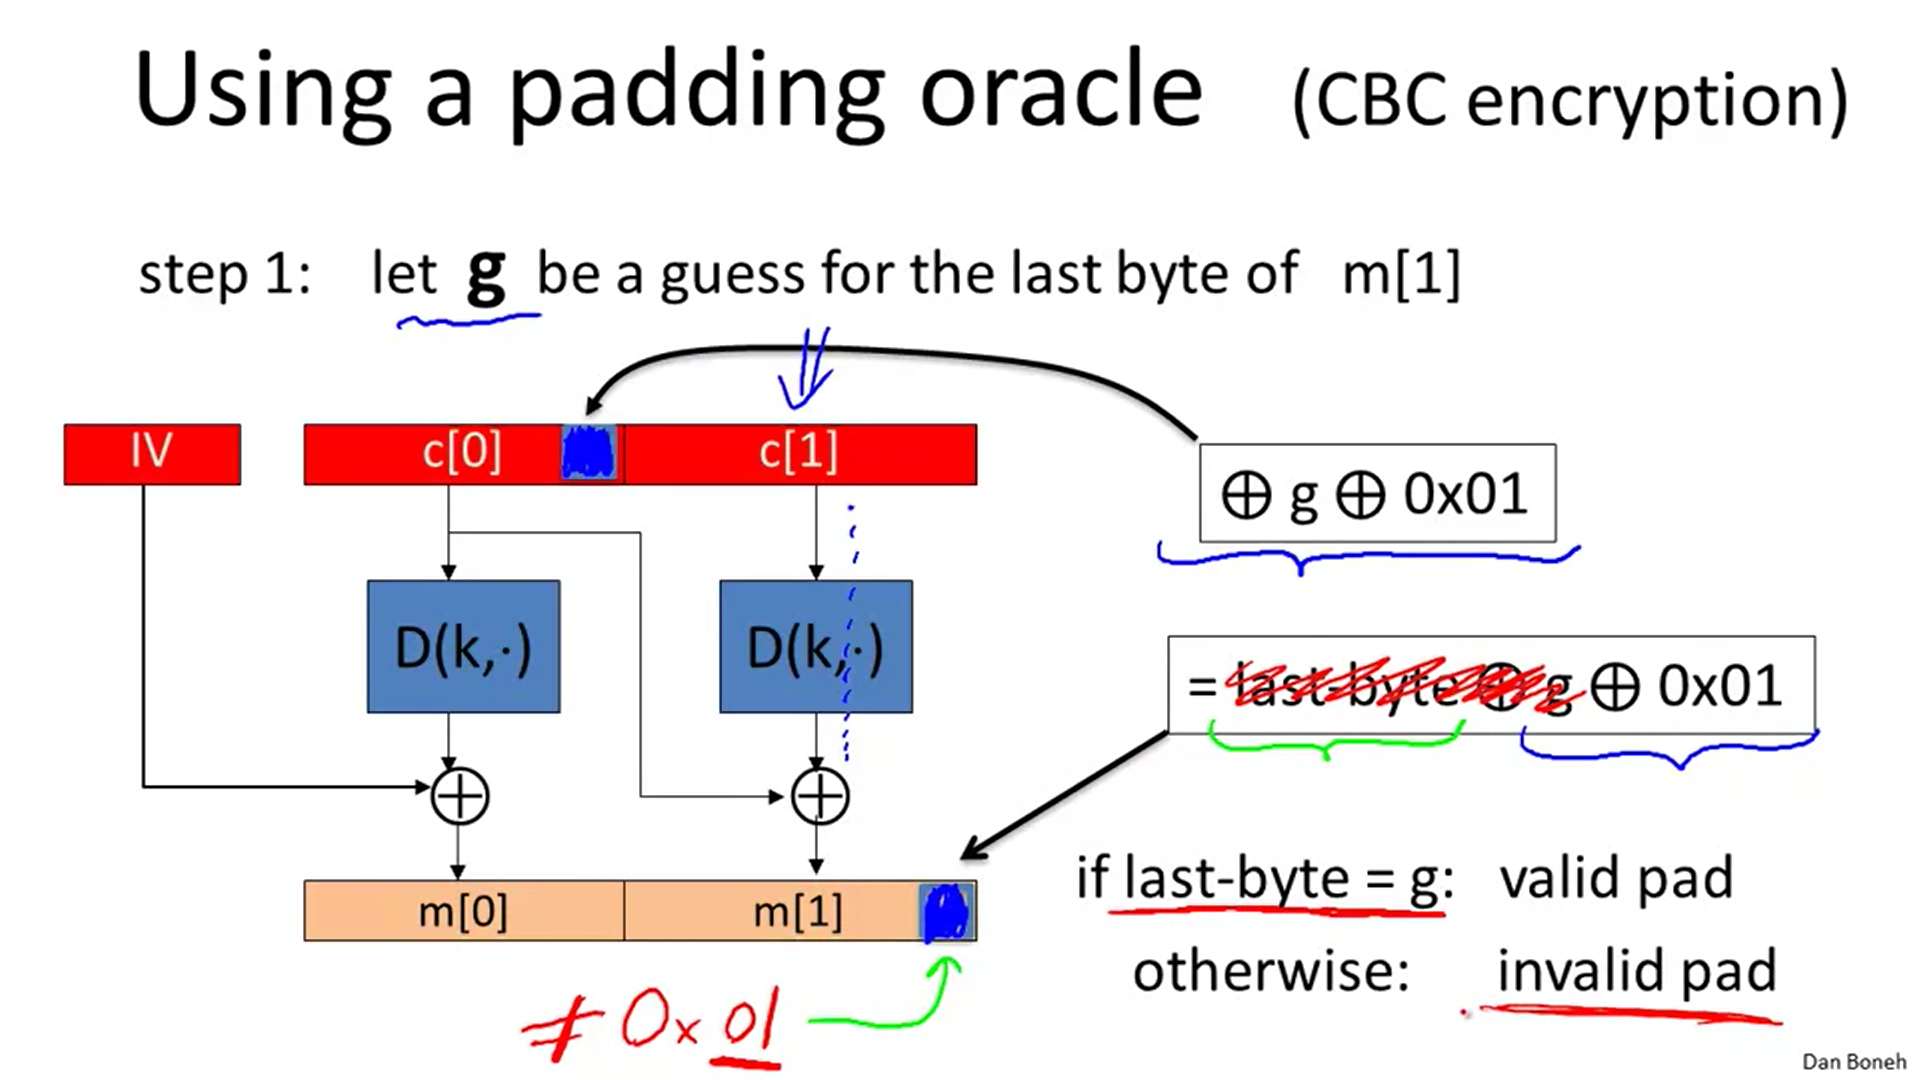

In [6]:
##pip install builtwith 

  Created wheel for builtwith: filename=builtwith-1.3.4-py3-none-any.whl size=36102 sha256=0445cba4e8385383a76370e178e1d44e16ca89b7bd3516f5f72e6471967e7c67
  Stored in directory: c:\users\noxre\appdata\local\pip\cache\wheels\72\37\d7\ee9677e57e69fec72898a783876aac646c041fa097e3a87631
Successfully built builtwith
Note: you may need to restart the kernel to use updated packages.


In [1]:
import urllib.request
import urllib.parse
import urllib.error
import sys

TARGET = 'http://crypto-class.appspot.com/po?er='
#--------------------------------------------------------------
# padding oracle
#--------------------------------------------------------------
class PaddingOracle(object):
    def query(self, q):
        target = TARGET + urllib.parse.quote(q)    # Create query URL
        try:
            f = urllib.request.urlopen(target)          # Send HTTP request to server, Wait for response
        except urllib.error.HTTPError as e:          
            print("We got: %d" % e.code)       # Print response code
            if e.code == 404:
                return True # good padding
            return False # bad padding

##if __name__ == "__main__":
##    po = PaddingOracle()
##    po.query(sys.argv[1])       # Issue HTTP query with the given argument

In [2]:
ct = "f20bdba6ff29eed7b046d1df9fb7000058b1ffb4210a580f748b4ac714c001bd4a61044426fb515dad3f21f18aa577c0bdf302936266926ff37dbf7035d5eeb4"
print(len(ct))

128


In [25]:
import binascii

def PODecrypt(ct):
    
    po = PaddingOracle()
    block_size = 32     # CBC block size = 16 bytes (32 hex char)
    block_num = int(len(ct)/block_size)
    all_bytes = []     # store the bytes decrypt
    
    ## decrypt a block each time, first block is IV, so total block = biock_num-1
    for n in range(block_num-1):
        
        print("next block")
        print(n)
        
        guess_block = ct[block_size*n:block_size*(n+1)]     # the block we use to guess this round
        later_block = ct[block_size*(n+1):block_size*(n+2)]     # the block of the cipher text's original message
        
        new_guess_block = guess_block     # update the correct guess byte
        get_byte = []     # store the correct guess byte this round
        
        ## decrypt from the last byte to first byte, pad should be 1 to 16
        for pad in range(1, 17):
            
            print(pad)
            
            if pad == 1:
                guess_byte = int(guess_block[-2:], 16)
                later_pad = ""
            else:
                guess_byte = int(new_guess_block[pad*(-2):pad*(-2)+2], 16)
                later_pad = new_guess_block[pad*(-2)+2:]
                print(later_pad)
                ## available pad should repeat its times, ex. pad=3 >> 030303, pad=5 >> 0505050505
                ## we store the correct guess byte xor original cipher byte follow by the byte we guess this round
                ## then we xor each byte in the later with pad to get correct pad whe decryption 
                for i in range(int(len(later_pad)/2)):
                    ## zfill(2) makes the hex always be 2 char
                    later_pad = later_pad[:2*i] + hex(int(later_pad[2*i:2*(i+1)], 16)^pad)[2:].zfill(2) + later_pad[2*(i+1):]
                print(later_pad)
            
            ## guess the byte from 0 to 255
            for guess in range(256):
                
                ## since the last block's last byte we guess may be pad itslef
                ## when the pad we use (1 for last byte) is equal to guess we use
                ## it will xor to nothing and input the original byte
                ## it will then return an avilabale pad since it was a pad originally
                ## but this result is not what we want, so we will skip this guess
                if n != block_num-2 or pad != 1 or guess != 1:
                    
                    guess_xor = hex(guess_byte^guess^pad)[2:].zfill(2)
                    print(guess_xor)
                    
                    ## input what we guess 
                    ## including preceding byte doesn't change, guess byte after xor, and the confirmed later bytes (after xor)
                    input_guess_block = new_guess_block[:pad*(-2)] + guess_xor + later_pad
                    
                    ## what we input will be the block we guess plus the encrypt text block of the plain test we want
                    try_input = input_guess_block + later_block
                    print(try_input)
                    
                    ## if it is an avilabel pad, which means the guess is right, it will return True
                    result = po.query(try_input)
                    
                    if result:
                        
                        ## we guess from the last, hence we add the new correct guess in front of the list
                        get_byte.insert(0, guess)
                        
                        ## store the new correct guess xor witn original ciphre byte to get use in next byte
                        update_guess = hex(guess_byte^guess)[2:].zfill(2)
                        
                        if pad == 1:
                            new_guess_block =  new_guess_block[:pad*(-2)] + update_guess
                        else:
                            new_guess_block =  new_guess_block[:pad*(-2)] + update_guess + new_guess_block[pad*(-2)+2:]
                            
                        print(new_guess_block)
                        break     # we get the correct byte, so we can move to next byte
        
        ## update the plain text we decrypt
        all_bytes = all_bytes + get_byte
        print(all_bytes)
    
    ## the plain text we store is decimal, we should convert it to words using ASCII
    pt = ""
    for h in all_bytes:
        ## remove the pad
        if int(h) > 16:
            decode = chr(int(h))
            pt = pt + decode
    
    return pt

In [26]:
pt = PODecrypt(ct)

next block
0
1
01
f20bdba6ff29eed7b046d1df9fb7000158b1ffb4210a580f748b4ac714c001bd
We got: 403
00
f20bdba6ff29eed7b046d1df9fb7000058b1ffb4210a580f748b4ac714c001bd
We got: 403
03
f20bdba6ff29eed7b046d1df9fb7000358b1ffb4210a580f748b4ac714c001bd
We got: 403
02
f20bdba6ff29eed7b046d1df9fb7000258b1ffb4210a580f748b4ac714c001bd
We got: 403
05
f20bdba6ff29eed7b046d1df9fb7000558b1ffb4210a580f748b4ac714c001bd
We got: 403
04
f20bdba6ff29eed7b046d1df9fb7000458b1ffb4210a580f748b4ac714c001bd
We got: 403
07
f20bdba6ff29eed7b046d1df9fb7000758b1ffb4210a580f748b4ac714c001bd
We got: 403
06
f20bdba6ff29eed7b046d1df9fb7000658b1ffb4210a580f748b4ac714c001bd
We got: 403
09
f20bdba6ff29eed7b046d1df9fb7000958b1ffb4210a580f748b4ac714c001bd
We got: 403
08
f20bdba6ff29eed7b046d1df9fb7000858b1ffb4210a580f748b4ac714c001bd
We got: 403
0b
f20bdba6ff29eed7b046d1df9fb7000b58b1ffb4210a580f748b4ac714c001bd
We got: 403
0a
f20bdba6ff29eed7b046d1df9fb7000a58b1ffb4210a580f748b4ac714c001bd
We got: 403
0d
f20bdba6ff29eed7b046d1

We got: 403
47
f20bdba6ff29eed7b046d1df9fb7472258b1ffb4210a580f748b4ac714c001bd
We got: 403
44
f20bdba6ff29eed7b046d1df9fb7442258b1ffb4210a580f748b4ac714c001bd
We got: 403
45
f20bdba6ff29eed7b046d1df9fb7452258b1ffb4210a580f748b4ac714c001bd
We got: 403
4a
f20bdba6ff29eed7b046d1df9fb74a2258b1ffb4210a580f748b4ac714c001bd
We got: 403
4b
f20bdba6ff29eed7b046d1df9fb74b2258b1ffb4210a580f748b4ac714c001bd
We got: 403
48
f20bdba6ff29eed7b046d1df9fb7482258b1ffb4210a580f748b4ac714c001bd
We got: 403
49
f20bdba6ff29eed7b046d1df9fb7492258b1ffb4210a580f748b4ac714c001bd
We got: 403
4e
f20bdba6ff29eed7b046d1df9fb74e2258b1ffb4210a580f748b4ac714c001bd
We got: 403
4f
f20bdba6ff29eed7b046d1df9fb74f2258b1ffb4210a580f748b4ac714c001bd
We got: 403
4c
f20bdba6ff29eed7b046d1df9fb74c2258b1ffb4210a580f748b4ac714c001bd
We got: 403
4d
f20bdba6ff29eed7b046d1df9fb74d2258b1ffb4210a580f748b4ac714c001bd
We got: 403
52
f20bdba6ff29eed7b046d1df9fb7522258b1ffb4210a580f748b4ac714c001bd
We got: 403
53
f20bdba6ff29eed7b046d1df9

We got: 403
83
f20bdba6ff29eed7b046d1df9f83702358b1ffb4210a580f748b4ac714c001bd
We got: 403
8c
f20bdba6ff29eed7b046d1df9f8c702358b1ffb4210a580f748b4ac714c001bd
We got: 403
8d
f20bdba6ff29eed7b046d1df9f8d702358b1ffb4210a580f748b4ac714c001bd
We got: 403
8e
f20bdba6ff29eed7b046d1df9f8e702358b1ffb4210a580f748b4ac714c001bd
We got: 403
8f
f20bdba6ff29eed7b046d1df9f8f702358b1ffb4210a580f748b4ac714c001bd
We got: 403
88
f20bdba6ff29eed7b046d1df9f88702358b1ffb4210a580f748b4ac714c001bd
We got: 403
89
f20bdba6ff29eed7b046d1df9f89702358b1ffb4210a580f748b4ac714c001bd
We got: 403
8a
f20bdba6ff29eed7b046d1df9f8a702358b1ffb4210a580f748b4ac714c001bd
We got: 403
8b
f20bdba6ff29eed7b046d1df9f8b702358b1ffb4210a580f748b4ac714c001bd
We got: 403
f4
f20bdba6ff29eed7b046d1df9ff4702358b1ffb4210a580f748b4ac714c001bd
We got: 403
f5
f20bdba6ff29eed7b046d1df9ff5702358b1ffb4210a580f748b4ac714c001bd
We got: 403
f6
f20bdba6ff29eed7b046d1df9ff6702358b1ffb4210a580f748b4ac714c001bd
We got: 403
f7
f20bdba6ff29eed7b046d1df9

We got: 403
a3
f20bdba6ff29eed7b046d1dfa3d7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
a2
f20bdba6ff29eed7b046d1dfa2d7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
a1
f20bdba6ff29eed7b046d1dfa1d7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
a0
f20bdba6ff29eed7b046d1dfa0d7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
a7
f20bdba6ff29eed7b046d1dfa7d7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
a6
f20bdba6ff29eed7b046d1dfa6d7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
a5
f20bdba6ff29eed7b046d1dfa5d7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
a4
f20bdba6ff29eed7b046d1dfa4d7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
db
f20bdba6ff29eed7b046d1dfdbd7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
da
f20bdba6ff29eed7b046d1dfdad7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
d9
f20bdba6ff29eed7b046d1dfd9d7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
d8
f20bdba6ff29eed7b046d1dfd8d7772458b1ffb4210a580f748b4ac714c001bd
We got: 403
df
f20bdba6ff29eed7b046d1dfd

We got: 403
f1
f20bdba6ff29eed7b046d1f1e8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
f6
f20bdba6ff29eed7b046d1f6e8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
f7
f20bdba6ff29eed7b046d1f7e8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
f4
f20bdba6ff29eed7b046d1f4e8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
f5
f20bdba6ff29eed7b046d1f5e8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
ea
f20bdba6ff29eed7b046d1eae8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
eb
f20bdba6ff29eed7b046d1ebe8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
e8
f20bdba6ff29eed7b046d1e8e8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
e9
f20bdba6ff29eed7b046d1e9e8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
ee
f20bdba6ff29eed7b046d1eee8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
ef
f20bdba6ff29eed7b046d1efe8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
ec
f20bdba6ff29eed7b046d1ece8d6762558b1ffb4210a580f748b4ac714c001bd
We got: 403
ed
f20bdba6ff29eed7b046d1ede

We got: 403
f6
f20bdba6ff29eed7b046f6b6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
f5
f20bdba6ff29eed7b046f5b6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
f4
f20bdba6ff29eed7b046f4b6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
f3
f20bdba6ff29eed7b046f3b6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
f2
f20bdba6ff29eed7b046f2b6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
f1
f20bdba6ff29eed7b046f1b6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
f0
f20bdba6ff29eed7b046f0b6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
ff
f20bdba6ff29eed7b046ffb6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
fe
f20bdba6ff29eed7b046feb6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
fd
f20bdba6ff29eed7b046fdb6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
fc
f20bdba6ff29eed7b046fcb6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
fb
f20bdba6ff29eed7b046fbb6ebd5752658b1ffb4210a580f748b4ac714c001bd
We got: 403
fa
f20bdba6ff29eed7b046fab6e

We got: 403
b5
f20bdba6ff29eed7b56e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
b6
f20bdba6ff29eed7b66e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
b7
f20bdba6ff29eed7b76e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
a8
f20bdba6ff29eed7a86e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
a9
f20bdba6ff29eed7a96e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
aa
f20bdba6ff29eed7aa6e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
ab
f20bdba6ff29eed7ab6e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
ac
f20bdba6ff29eed7ac6e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
ad
f20bdba6ff29eed7ad6e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
ae
f20bdba6ff29eed7ae6e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
af
f20bdba6ff29eed7af6e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
a0
f20bdba6ff29eed7a06e8eb8e5db7b2858b1ffb4210a580f748b4ac714c001bd
We got: 403
a1
f20bdba6ff29eed7a16e8eb8e

We got: 403
d1
f20bdba6ff29eed1da6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
ce
f20bdba6ff29eeceda6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
cf
f20bdba6ff29eecfda6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
cc
f20bdba6ff29eeccda6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
cd
f20bdba6ff29eecdda6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
ca
f20bdba6ff29eecada6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
cb
f20bdba6ff29eecbda6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
c8
f20bdba6ff29eec8da6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
c9
f20bdba6ff29eec9da6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
c6
f20bdba6ff29eec6da6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
c7
f20bdba6ff29eec7da6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
c4
f20bdba6ff29eec4da6f8fb9e4da7a2958b1ffb4210a580f748b4ac714c001bd
We got: 403
c5
f20bdba6ff29eec5da6f8fb9e

We got: 403
ef
f20bdba6ff29efb4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
e8
f20bdba6ff29e8b4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
e9
f20bdba6ff29e9b4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
ea
f20bdba6ff29eab4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
eb
f20bdba6ff29ebb4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
f4
f20bdba6ff29f4b4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
f5
f20bdba6ff29f5b4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
f6
f20bdba6ff29f6b4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
f7
f20bdba6ff29f7b4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
f0
f20bdba6ff29f0b4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
f1
f20bdba6ff29f1b4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
f2
f20bdba6ff29f2b4d96c8cbae7d9792a58b1ffb4210a580f748b4ac714c001bd
We got: 403
f3
f20bdba6ff29f3b4d96c8cbae

We got: 403
2b
f20bdba6ff2b82b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
28
f20bdba6ff2882b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
29
f20bdba6ff2982b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
2e
f20bdba6ff2e82b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
2f
f20bdba6ff2f82b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
2c
f20bdba6ff2c82b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
2d
f20bdba6ff2d82b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
32
f20bdba6ff3282b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
33
f20bdba6ff3382b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
30
f20bdba6ff3082b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
31
f20bdba6ff3182b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
36
f20bdba6ff3682b5d86d8dbbe6d8782b58b1ffb4210a580f748b4ac714c001bd
We got: 403
37
f20bdba6ff3782b5d86d8dbbe

We got: 403
fe
f20bdba6fe4485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
fd
f20bdba6fd4485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
fc
f20bdba6fc4485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
e3
f20bdba6e34485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
e2
f20bdba6e24485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
e1
f20bdba6e14485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
e0
f20bdba6e04485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
e7
f20bdba6e74485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
e6
f20bdba6e64485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
e5
f20bdba6e54485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
e4
f20bdba6e44485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
eb
f20bdba6eb4485b2df6a8abce1df7f2c58b1ffb4210a580f748b4ac714c001bd
We got: 403
ea
f20bdba6ea4485b2df6a8abce

We got: 403
d6
f20bd688bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
d1
f20bd188bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
d0
f20bd088bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
d3
f20bd388bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
d2
f20bd288bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
dd
f20bdd88bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
dc
f20bdc88bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
df
f20bdf88bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
de
f20bde88bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
d9
f20bd988bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
d8
f20bd888bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
db
f20bdb88bc4687b0dd6888bee3dd7d2e58b1ffb4210a580f748b4ac714c001bd
We got: 403
da
f20bda88bc4687b0dd6888bee

We got: 403
07
f207b189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
00
f200b189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
01
f201b189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
02
f202b189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
03
f203b189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
0c
f20cb189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
0d
f20db189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
0e
f20eb189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
0f
f20fb189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
08
f208b189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
09
f209b189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
0a
f20ab189bd4786b1dc6989bfe2dc7c2f58b1ffb4210a580f748b4ac714c001bd
We got: 403
0b
f20bb189bd4786b1dc6989bfe

We got: 403
e3
e373ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
e0
e073ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
e1
e173ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
e6
e673ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
e7
e773ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
e4
e473ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
e5
e573ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
ea
ea73ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
eb
eb73ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
e8
e873ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
e9
e973ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
ee
ee73ae96a25899aec37696a0fdc3633058b1ffb4210a580f748b4ac714c001bd
We got: 403
ef
ef73ae96a25899aec37696a0f

We got: 403
ad
58b1ffb4210a580f748b4ac714c001ad4a61044426fb515dad3f21f18aa577c0
We got: 403
ae
58b1ffb4210a580f748b4ac714c001ae4a61044426fb515dad3f21f18aa577c0
We got: 403
af
58b1ffb4210a580f748b4ac714c001af4a61044426fb515dad3f21f18aa577c0
We got: 403
a8
58b1ffb4210a580f748b4ac714c001a84a61044426fb515dad3f21f18aa577c0
We got: 403
a9
58b1ffb4210a580f748b4ac714c001a94a61044426fb515dad3f21f18aa577c0
We got: 403
aa
58b1ffb4210a580f748b4ac714c001aa4a61044426fb515dad3f21f18aa577c0
We got: 403
ab
58b1ffb4210a580f748b4ac714c001ab4a61044426fb515dad3f21f18aa577c0
We got: 403
a4
58b1ffb4210a580f748b4ac714c001a44a61044426fb515dad3f21f18aa577c0
We got: 403
a5
58b1ffb4210a580f748b4ac714c001a54a61044426fb515dad3f21f18aa577c0
We got: 403
a6
58b1ffb4210a580f748b4ac714c001a64a61044426fb515dad3f21f18aa577c0
We got: 403
a7
58b1ffb4210a580f748b4ac714c001a74a61044426fb515dad3f21f18aa577c0
We got: 403
a0
58b1ffb4210a580f748b4ac714c001a04a61044426fb515dad3f21f18aa577c0
We got: 403
a1
58b1ffb4210a580f748b4ac71

We got: 403
00
58b1ffb4210a580f748b4ac714c000cc4a61044426fb515dad3f21f18aa577c0
We got: 403
07
58b1ffb4210a580f748b4ac714c007cc4a61044426fb515dad3f21f18aa577c0
We got: 403
06
58b1ffb4210a580f748b4ac714c006cc4a61044426fb515dad3f21f18aa577c0
We got: 403
05
58b1ffb4210a580f748b4ac714c005cc4a61044426fb515dad3f21f18aa577c0
We got: 403
04
58b1ffb4210a580f748b4ac714c004cc4a61044426fb515dad3f21f18aa577c0
We got: 403
0b
58b1ffb4210a580f748b4ac714c00bcc4a61044426fb515dad3f21f18aa577c0
We got: 403
0a
58b1ffb4210a580f748b4ac714c00acc4a61044426fb515dad3f21f18aa577c0
We got: 403
09
58b1ffb4210a580f748b4ac714c009cc4a61044426fb515dad3f21f18aa577c0
We got: 403
08
58b1ffb4210a580f748b4ac714c008cc4a61044426fb515dad3f21f18aa577c0
We got: 403
0f
58b1ffb4210a580f748b4ac714c00fcc4a61044426fb515dad3f21f18aa577c0
We got: 403
0e
58b1ffb4210a580f748b4ac714c00ecc4a61044426fb515dad3f21f18aa577c0
We got: 403
0d
58b1ffb4210a580f748b4ac714c00dcc4a61044426fb515dad3f21f18aa577c0
We got: 403
0c
58b1ffb4210a580f748b4ac71

We got: 403
da
58b1ffb4210a580f748b4ac714da4dcd4a61044426fb515dad3f21f18aa577c0
We got: 403
d9
58b1ffb4210a580f748b4ac714d94dcd4a61044426fb515dad3f21f18aa577c0
We got: 403
d8
58b1ffb4210a580f748b4ac714d84dcd4a61044426fb515dad3f21f18aa577c0
We got: 403
df
58b1ffb4210a580f748b4ac714df4dcd4a61044426fb515dad3f21f18aa577c0
We got: 403
de
58b1ffb4210a580f748b4ac714de4dcd4a61044426fb515dad3f21f18aa577c0
We got: 403
dd
58b1ffb4210a580f748b4ac714dd4dcd4a61044426fb515dad3f21f18aa577c0
We got: 403
dc
58b1ffb4210a580f748b4ac714dc4dcd4a61044426fb515dad3f21f18aa577c0
We got: 403
e3
58b1ffb4210a580f748b4ac714e34dcd4a61044426fb515dad3f21f18aa577c0
We got: 404
58b1ffb4210a580f748b4ac714e04ece
4
e04ece
e44aca
10
58b1ffb4210a580f748b4ac710e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
11
58b1ffb4210a580f748b4ac711e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
12
58b1ffb4210a580f748b4ac712e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
13
58b1ffb4210a580f748b4ac713e44aca4a61044426fb515dad3f21f1

We got: 403
4e
58b1ffb4210a580f748b4ac74ee44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
4f
58b1ffb4210a580f748b4ac74fe44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
70
58b1ffb4210a580f748b4ac770e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
71
58b1ffb4210a580f748b4ac771e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
72
58b1ffb4210a580f748b4ac772e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
73
58b1ffb4210a580f748b4ac773e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
74
58b1ffb4210a580f748b4ac774e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
75
58b1ffb4210a580f748b4ac775e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
76
58b1ffb4210a580f748b4ac776e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
77
58b1ffb4210a580f748b4ac777e44aca4a61044426fb515dad3f21f18aa577c0
We got: 403
78
58b1ffb4210a580f748b4ac778e44aca4a61044426fb515dad3f21f18aa577c0
We got: 404
58b1ffb4210a580f748b4ac77ce04ece
5
7ce04ece
79e54bcb
c2
58b1ffb4210a580f748b4ac279e54bcb4a61044426fb515dad3f

We got: 403
99
58b1ffb4210a580f748b4a9979e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
9e
58b1ffb4210a580f748b4a9e79e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
9f
58b1ffb4210a580f748b4a9f79e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
9c
58b1ffb4210a580f748b4a9c79e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
9d
58b1ffb4210a580f748b4a9d79e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
a2
58b1ffb4210a580f748b4aa279e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
a3
58b1ffb4210a580f748b4aa379e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
a0
58b1ffb4210a580f748b4aa079e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
a1
58b1ffb4210a580f748b4aa179e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
a6
58b1ffb4210a580f748b4aa679e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
a7
58b1ffb4210a580f748b4aa779e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
a4
58b1ffb4210a580f748b4aa479e54bcb4a61044426fb515dad3f21f18aa577c0
We got: 403
a5
58b1ffb4210a580f748b4aa57

We got: 403
01
58b1ffb4210a580f748b01b27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
02
58b1ffb4210a580f748b02b27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
03
58b1ffb4210a580f748b03b27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
1c
58b1ffb4210a580f748b1cb27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
1d
58b1ffb4210a580f748b1db27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
1e
58b1ffb4210a580f748b1eb27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
1f
58b1ffb4210a580f748b1fb27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
18
58b1ffb4210a580f748b18b27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
19
58b1ffb4210a580f748b19b27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
1a
58b1ffb4210a580f748b1ab27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
1b
58b1ffb4210a580f748b1bb27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
14
58b1ffb4210a580f748b14b27ae648c84a61044426fb515dad3f21f18aa577c0
We got: 403
15
58b1ffb4210a580f748b15b27

We got: 403
c5
58b1ffb4210a580f74c524b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
c6
58b1ffb4210a580f74c624b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
c7
58b1ffb4210a580f74c724b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
c0
58b1ffb4210a580f74c024b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
c1
58b1ffb4210a580f74c124b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
c2
58b1ffb4210a580f74c224b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
c3
58b1ffb4210a580f74c324b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
dc
58b1ffb4210a580f74dc24b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
dd
58b1ffb4210a580f74dd24b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
de
58b1ffb4210a580f74de24b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
df
58b1ffb4210a580f74df24b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
d8
58b1ffb4210a580f74d824b37be749c94a61044426fb515dad3f21f18aa577c0
We got: 403
d9
58b1ffb4210a580f74d924b37

We got: 403
3d
58b1ffb4210a580f3dee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
3e
58b1ffb4210a580f3eee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
3f
58b1ffb4210a580f3fee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
38
58b1ffb4210a580f38ee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
39
58b1ffb4210a580f39ee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
3a
58b1ffb4210a580f3aee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
3b
58b1ffb4210a580f3bee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
34
58b1ffb4210a580f34ee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
35
58b1ffb4210a580f35ee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
36
58b1ffb4210a580f36ee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
37
58b1ffb4210a580f37ee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
30
58b1ffb4210a580f30ee2bbc74e846c64a61044426fb515dad3f21f18aa577c0
We got: 403
31
58b1ffb4210a580f31ee2bbc7

We got: 403
43
58b1ffb4210a58431cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
40
58b1ffb4210a58401cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
41
58b1ffb4210a58411cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
4e
58b1ffb4210a584e1cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
4f
58b1ffb4210a584f1cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
4c
58b1ffb4210a584c1cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
4d
58b1ffb4210a584d1cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
4a
58b1ffb4210a584a1cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
4b
58b1ffb4210a584b1cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
48
58b1ffb4210a58481cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
49
58b1ffb4210a58491cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
56
58b1ffb4210a58561cef2abd75e947c74a61044426fb515dad3f21f18aa577c0
We got: 403
57
58b1ffb4210a58571cef2abd7

We got: 403
17
58b1ffb4210a17601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
14
58b1ffb4210a14601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
15
58b1ffb4210a15601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
1a
58b1ffb4210a1a601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
1b
58b1ffb4210a1b601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
18
58b1ffb4210a18601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
19
58b1ffb4210a19601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
1e
58b1ffb4210a1e601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
1f
58b1ffb4210a1f601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
1c
58b1ffb4210a1c601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
1d
58b1ffb4210a1d601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
02
58b1ffb4210a02601fec29be76ea44c44a61044426fb515dad3f21f18aa577c0
We got: 403
03
58b1ffb4210a03601fec29be7

We got: 403
34
58b1ffb4213426611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
37
58b1ffb4213726611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
36
58b1ffb4213626611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
39
58b1ffb4213926611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
38
58b1ffb4213826611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
3b
58b1ffb4213b26611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
3a
58b1ffb4213a26611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
3d
58b1ffb4213d26611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
3c
58b1ffb4213c26611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
3f
58b1ffb4213f26611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
3e
58b1ffb4213e26611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
41
58b1ffb4214126611eed28bf77eb45c54a61044426fb515dad3f21f18aa577c0
We got: 403
40
58b1ffb4214026611eed28bf7

We got: 403
04
58b1ffb40477216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
07
58b1ffb40777216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
06
58b1ffb40677216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
01
58b1ffb40177216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
00
58b1ffb40077216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
03
58b1ffb40377216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
02
58b1ffb40277216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
1d
58b1ffb41d77216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
1c
58b1ffb41c77216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
1f
58b1ffb41f77216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
1e
58b1ffb41e77216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
19
58b1ffb41977216619ea2fb870ec42c24a61044426fb515dad3f21f18aa577c0
We got: 403
18
58b1ffb41877216619ea2fb87

We got: 403
e8
58b1e89a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
eb
58b1eb9a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
ea
58b1ea9a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
ed
58b1ed9a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
ec
58b1ec9a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
ef
58b1ef9a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
ee
58b1ee9a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
d1
58b1d19a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
d0
58b1d09a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
d3
58b1d39a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
d2
58b1d29a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
d5
58b1d59a7c7523641be82dba72ee40c04a61044426fb515dad3f21f18aa577c0
We got: 403
d4
58b1d49a7c7523641be82dba7

We got: 403
a7
58a7959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
a4
58a4959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
a5
58a5959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
a2
58a2959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
a3
58a3959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
a0
58a0959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
a1
58a1959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
9e
589e959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
9f
589f959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
9c
589c959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
9d
589d959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
9a
589a959b7d7422651ae92cbb73ef41c14a61044426fb515dad3f21f18aa577c0
We got: 403
9b
589b959b7d7422651ae92cbb7

We got: 403
44
44d38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
45
45d38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
46
46d38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
47
47d38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
58
58d38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
59
59d38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
5a
5ad38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
5b
5bd38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
5c
5cd38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
5d
5dd38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
5e
5ed38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
5f
5fd38a84626b3d7a05f633a46cf05ede4a61044426fb515dad3f21f18aa577c0
We got: 403
50
50d38a84626b3d7a05f633a46

We got: 403
70
4a61044426fb515dad3f21f18aa570cbbdf302936266926ff37dbf7035d5eeb4
We got: 403
73
4a61044426fb515dad3f21f18aa573cbbdf302936266926ff37dbf7035d5eeb4
We got: 403
72
4a61044426fb515dad3f21f18aa572cbbdf302936266926ff37dbf7035d5eeb4
We got: 403
7d
4a61044426fb515dad3f21f18aa57dcbbdf302936266926ff37dbf7035d5eeb4
We got: 403
7c
4a61044426fb515dad3f21f18aa57ccbbdf302936266926ff37dbf7035d5eeb4
We got: 404
4a61044426fb515dad3f21f18aa57ec9
3
7ec9
7dca
a6
4a61044426fb515dad3f21f18aa67dcabdf302936266926ff37dbf7035d5eeb4
We got: 403
a7
4a61044426fb515dad3f21f18aa77dcabdf302936266926ff37dbf7035d5eeb4
We got: 403
a4
4a61044426fb515dad3f21f18aa47dcabdf302936266926ff37dbf7035d5eeb4
We got: 403
a5
4a61044426fb515dad3f21f18aa57dcabdf302936266926ff37dbf7035d5eeb4
We got: 403
a2
4a61044426fb515dad3f21f18aa27dcabdf302936266926ff37dbf7035d5eeb4
We got: 403
a3
4a61044426fb515dad3f21f18aa37dcabdf302936266926ff37dbf7035d5eeb4
We got: 403
a0
4a61044426fb515dad3f21f18aa07dcabdf302936266926ff37dbf7035d5

We got: 403
4d
4a61044426fb4d5eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
4c
4a61044426fb4c5eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
43
4a61044426fb435eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
42
4a61044426fb425eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
41
4a61044426fb415eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
40
4a61044426fb405eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
47
4a61044426fb475eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
46
4a61044426fb465eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
45
4a61044426fb455eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
44
4a61044426fb445eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
7b
4a61044426fb7b5eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
7a
4a61044426fb7a5eae3c22f289a674c3bdf302936266926ff37dbf7035d5eeb4
We got: 403
79
4a61044426fb795eae3c22f28

We got: 403
e6
4a61044426e63f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
e7
4a61044426e73f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
e8
4a61044426e83f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
e9
4a61044426e93f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
ea
4a61044426ea3f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
eb
4a61044426eb3f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
ec
4a61044426ec3f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
ed
4a61044426ed3f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
ee
4a61044426ee3f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
ef
4a61044426ef3f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
d0
4a61044426d03f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
d1
4a61044426d13f5faf3d23f388a775c2bdf302936266926ff37dbf7035d5eeb4
We got: 403
d2
4a61044426d23f5faf3d23f38

We got: 403
3e
4a6104443e903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
3f
4a6104443f903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
3c
4a6104443c903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
3d
4a6104443d903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
32
4a61044432903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
33
4a61044433903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
30
4a61044430903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
31
4a61044431903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
36
4a61044436903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
37
4a61044437903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
34
4a61044434903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
35
4a61044435903858a83a24f48fa072c5bdf302936266926ff37dbf7035d5eeb4
We got: 403
0a
4a6104440a903858a83a24f48

We got: 403
51
4a6104514a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
50
4a6104504a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
53
4a6104534a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
52
4a6104524a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
55
4a6104554a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
54
4a6104544a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
57
4a6104574a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
56
4a6104564a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
69
4a6104694a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
68
4a6104684a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
6b
4a61046b4a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
6a
4a61046a4a913959a93b25f58ea173c4bdf302936266926ff37dbf7035d5eeb4
We got: 403
6d
4a61046d4a913959a93b25f58

We got: 403
01
4a61013849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
06
4a61063849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
07
4a61073849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
04
4a61043849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
05
4a61053849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
1a
4a611a3849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
1b
4a611b3849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
18
4a61183849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
19
4a61193849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
1e
4a611e3849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
1f
4a611f3849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
1c
4a611c3849923a5aaa3826f68da270c7bdf302936266926ff37dbf7035d5eeb4
We got: 403
1d
4a611d3849923a5aaa3826f68

We got: 403
64
4a646d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
65
4a656d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
62
4a626d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
63
4a636d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
60
4a606d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
61
4a616d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
7e
4a7e6d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
7f
4a7f6d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
7c
4a7c6d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
7d
4a7d6d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
7a
4a7a6d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
7b
4a7b6d3948933b5bab3927f78ca371c6bdf302936266926ff37dbf7035d5eeb4
We got: 403
78
4a786d3948933b5bab3927f78

We got: 403
5c
5c187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
5d
5d187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
52
52187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
53
53187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
50
50187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
51
51187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
56
56187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
57
57187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
54
54187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
55
55187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
4a
4a187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
4b
4b187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
48
48187226578c2444b42638e89

We got: 403
37
37187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
34
34187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
35
35187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
2a
2a187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
2b
2b187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
28
28187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 403
29
29187226578c2444b42638e893bc6ed9bdf302936266926ff37dbf7035d5eeb4
We got: 404
39086236479c3454a43628f883ac7ec9
[84, 104, 101, 32, 77, 97, 103, 105, 99, 32, 87, 111, 114, 100, 115, 32, 97, 114, 101, 32, 83, 113, 117, 101, 97, 109, 105, 115, 104, 32, 79, 115, 115, 105, 102, 114, 97, 103, 101, 9, 9, 9, 9, 9, 9, 9, 9, 9]


In [27]:
print(pt)

The Magic Words are Squeamish Ossifrage									
